In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib as plt
from matplotlib import pyplot  as plt
from google.colab import files


In [4]:
#!pip install torch
!pip install hmmlearn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 1.5 MB/s eta 0:00:00


In [5]:
import yfinance as yf
from hmmlearn.hmm import GaussianHMM
import sklearn.mixture as mix

In [6]:
!pip install pandas-ta
import pandas_ta as pta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=54c26fe1e2244b541c6c0465554fddf76378dd0979ea1b0fa21d85fe9348ad71
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [7]:
!pip install ta
import ta
from ta.momentum import RSIIndicator
from ta.momentum import StochasticOscillator
from ta.trend import ADXIndicator
from ta.volatility import BollingerBands
from ta.volatility import DonchianChannel
from ta.volatility import AverageTrueRange

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=8d1e8d5239b0be23a41e0636ce915f6f087b127ad559486f0ea065e8913168b8
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [8]:
import warnings
warnings.filterwarnings('ignore')


In [403]:
#tkr = 'MARUTI.NS'
#tkr = 'INDUSINDBK.NS'
#tkr = 'CANBK.NS'
#tkr = 'GOOG'
#tkr = 'NVDA'
#tkr = 'HDFCBANK.NS'
tkr = "^NSEI"
start_dt ='2019-03-01'
end_dt ='2024-12-31'
data = yf.download(tkr, start = start_dt , end=end_dt, period = '1d')

#Adjust High, Low, Open Close prices.
data['Open'] = data['Open']*data['Adj Close']/data['Close']
data['High'] = data['High']*data['Adj Close']/data['Close']
data['Low'] = data['Low']*data['Adj Close']/data['Close']
data['Close'] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed


In [404]:
#MACD uisng TA Pkg
macd_obj = ta.trend.MACD(data['Close'])
data['ta-macd'] = macd_obj.macd()
data['ta-macd-sig'] = macd_obj.macd_signal()
data['ta-macd-sig%'] = data['ta-macd']/data['ta-macd-sig']

#RSI using Pandas TA package
df1 = pta.rsi(data['Close'])
df1.rename('pta-rsi', inplace=True)
data = pd.concat([data, df1], axis=1)
#data['pta-rsi%-25'] = data['pta-rsi']/25.0

#Awesome Osc using Pandas TA package
#df1 = pta.ao(data['High'],data['Low'])
#df1.rename('pta-ao', inplace=True)
#data = pd.concat([data, df1], axis=1)

#Stoch indicator using Pandas TA pkg
#df = pta.stoch(data['High'],data['Low'],data['Close'])
#df.rename(columns={'STOCHk_14_3_3':'pta-stochk','STOCHd_14_3_3':'pta-stochd'}, inplace=True)
#data = pd.concat([data, df.pop('pta-stochd')], axis=1)

#Stochastic Oscillator using TA pkg
#stoch = StochasticOscillator(data['High'],data['Low'],data['Close'])
#data['ta-stoch'] = stoch.stoch()

df = pta.vwap(data['High'],data['Low'],data['Close'], data['Volume'])
df.rename('pta-vwap', inplace=True)
data = pd.concat([data, df], axis=1)

data['pta-kama'] = pta.kama(data['Close'], 20, 2, 20)

#ADX using Pandas TA pkg
df = pta.adx(data['High'],data['Low'],data['Close'])
df.rename(columns={'ADX_14':'pta-adx','DMP_14':'pta-adx-dmp','DMN_14':'pta-adx-dmn'}, inplace=True)
data = pd.concat([data, df], axis=1)

#data['pta-adx%-25'] = data['pta-adx']/25
data['pta-adx-pn'] = data['pta-adx-dmp']/data['pta-adx-dmn']

#Volatility
bollinger = BollingerBands(data['Close'])
ta_boll_pband = bollinger.bollinger_pband()
ta_boll_wband = bollinger.bollinger_wband()
data['ta-boll-pband'] = bollinger.bollinger_pband()
data['ta-boll-wband'] = bollinger.bollinger_wband()
donchian = DonchianChannel(data['High'], data['Low'], data['Close'])
ta_donch_pband = donchian.donchian_channel_pband()
ta_donch_wband = donchian.donchian_channel_wband()
data['ta-donch-pband'] = donchian.donchian_channel_pband()
data['ta-donch-wband'] = donchian.donchian_channel_wband()
keltner = ta.volatility.KeltnerChannel(data['High'], data['Low'], data['Close'])
data['ta-kelt-pband'] = keltner.keltner_channel_pband()
data['ta-kelt-wband'] = keltner.keltner_channel_wband()

data['ta-vol-pband'] = (ta_boll_pband + ta_donch_pband)/2.
data['ta-vol-wband'] = (ta_boll_wband + ta_donch_wband)/2.

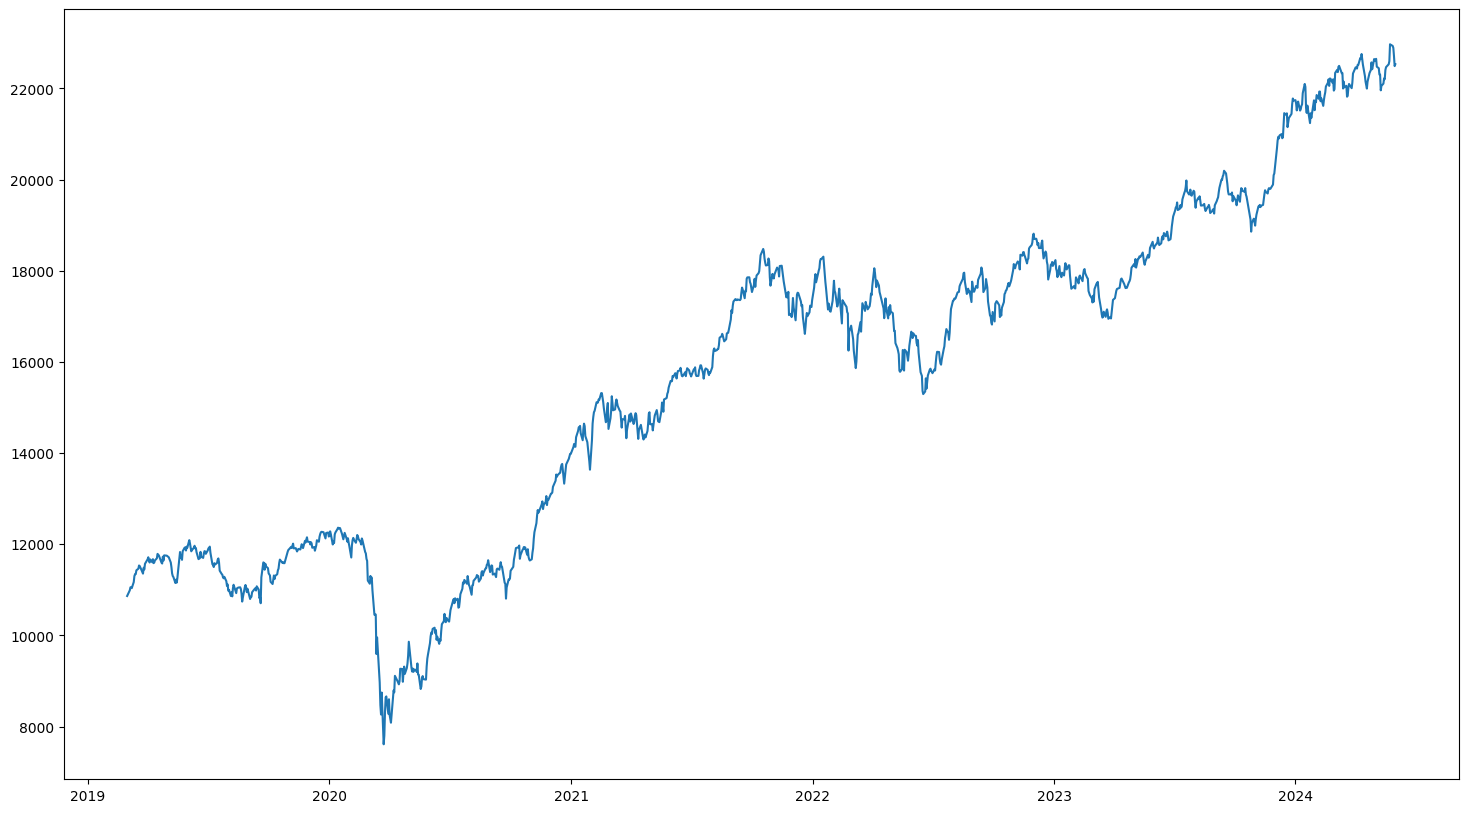

In [405]:
fig = plt.figure(figsize = (18,10))
plt.plot(data['Close'])

In [482]:
df = data.copy()
df['sma'] = df["Close"].rolling(5).mean()
df["Log"] = np.log(df["sma"])
#df["Log"] = np.log(df["pta-kama"])
df["Returns"] = df["Log"].pct_change()
df["Range"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)
df = df.drop(['Open', 'High', 'Low', 'Adj Close'], axis=1)
df.head()

,Close,Volume,ta-macd,ta-macd-sig,ta-macd-sig%,pta-rsi,pta-vwap,pta-kama,pta-adx,pta-adx-dmp,...,ta-donch-pband,ta-donch-wband,ta-kelt-pband,ta-kelt-wband,ta-vol-pband,ta-vol-wband,sma,Log,Returns,Range
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-24,11726.150391,335200,107.349232,125.837487,0.853078,61.334420,11681.949870,7919.340815,40.006830,34.019555,...,0.761271,4.686917,1.004644,1.840077,0.763078,4.091963,11687.300195,9.366258,0.000065,0.013991
2019-04-25,11641.799805,604400,99.067598,120.483509,0.822250,55.879943,11687.616536,8077.288382,39.552667,33.839039,...,0.574448,4.329961,0.530750,1.913415,0.550863,3.566548,11658.230078,9.363768,-0.000266,0.014835
2019-04-26,11754.650391,333500,100.452489,116.477305,0.862421,60.890965,11726.433594,8225.736555,39.147354,31.185163,...,0.770958,3.805017,0.983633,1.874056,0.808853,3.241846,11658.600195,9.363799,0.000003,0.008674
2019-04-30,11748.150391,532600,99.874241,113.156692,0.882619,60.464986,11720.100260,8389.876932,38.681205,29.145370,...,0.732475,3.461782,0.902191,1.843861,0.780375,2.860921,11689.340234,9.366433,0.000281,0.008609
2019-05-02,11724.750000,380300,96.416333,109.808620,0.878040,58.868329,11737.866536,8476.872753,38.550036,29.600472,...,0.572056,2.631255,0.752081,1.802606,0.644662,2.407823,11719.100195,9.368975,0.000271,0.007671


In [407]:
df.shape

(1248, 24)

In [483]:
X = df[["Returns", 'pta-rsi', 'pta-adx-pn',  'ta-vol-pband', 'ta-vol-wband']][:]
X_train = df[["Returns",'pta-rsi', 'pta-adx-pn', 'ta-vol-pband', 'ta-vol-wband']].iloc[0:1100,:]
X_test = df[["Returns", 'pta-rsi',  'pta-adx-pn', 'ta-vol-pband', 'ta-vol-wband']].iloc[1100:,:]

#X_train = df[["Returns", "Range", 'pta-adx', 'pta-adx-dmp', 'pta-adx-dmn','pta-vwap', 'Volume', 'pta-rsi']].iloc[80:1300,:]
#X_test = df[["Returns", "Range", 'pta-adx', 'pta-adx-dmp', 'pta-adx-dmn', 'pta-vwap', 'Volume', 'pta-rsi']].iloc[1300:,:]

#X_train = df[["Returns"]].iloc[:3800]
#X_test = df[["Returns"]].iloc[3800:]

X_train.shape, X_test.shape

((1100, 5), (148, 5))

In [484]:
prices = df['Close'].iloc[:1100]
prices_test = df['Close'].iloc[1100:]
kama = df['pta-kama'].iloc[:1100]
kama_test = df['pta-kama'].iloc[1100:]

#prices = kama
#prices_test = kama_test

In [487]:
# Fit Model
# INITIAL VIDEO SHOWED GMM (above) - BUT HMM SEEMS BETTER?
hmm_model = GaussianHMM(n_components=6, covariance_type="full", n_iter=9000).fit(X_train)
print("Model Score:", hmm_model.score(X_train))

Model Score: -155.1304904258831


In [488]:
#Load Model
#hmm_model = pickle.load(open(pickle_path, "rb"))
import pickle
#pickle_path = "drive/MyDrive/Colab Notebooks/models/hmm-regime-switching/GOOG_regime_switching.pkl"
#with open(pickle_path, "wb") as file: pickle.dump(hmm_model, file)
#hmm_model = pickle.load(open(pickle_path, "rb"))
#with open("CANBK_regime_switching.pkl", "rb") as file: pickle.load(file)

In [489]:
# Check results
hidden_states = hmm_model.predict(X_train)
hidden_states[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1, 1, 1, 1, 5, 3, 3, 3])

In [490]:
# Structure prices for chart plotting
i = 0
labels_0 = []
labels_1 = []
labels_2 = []
labels_3 = []
labels_5 = []
labels_4 = []
labels_6 = []
labels_7 = []
labels_8 = []

#prices = df["Close"].values.astype(float)
print("Correct Number of rows: ", len(prices) == len(hidden_states))
for s in hidden_states:
    if s == 0:
        labels_0.append(prices[i])
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
        labels_5.append(float('nan'))
        labels_4.append(float('nan'))
        labels_6.append(float('nan'))
        labels_7.append(float('nan'))
        labels_8.append(float('nan'))
    if s == 1:
        labels_0.append(float('nan'))
        labels_1.append(prices[i])
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
        labels_5.append(float('nan'))
        labels_4.append(float('nan'))
        labels_6.append(float('nan'))
        labels_7.append(float('nan'))
        labels_8.append(float('nan'))
    if s == 2:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(prices[i])
        labels_3.append(float('nan'))
        labels_5.append(float('nan'))
        labels_4.append(float('nan'))
        labels_6.append(float('nan'))
        labels_7.append(float('nan'))
        labels_8.append(float('nan'))
    if s == 3:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(prices[i])
        labels_5.append(float('nan'))
        labels_4.append(float('nan'))
        labels_6.append(float('nan'))
        labels_7.append(float('nan'))
        labels_8.append(float('nan'))
    if s == 5:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
        labels_5.append(prices[i])
        labels_4.append(float('nan'))
        labels_6.append(float('nan'))
        labels_7.append(float('nan'))
        labels_8.append(float('nan'))
    if s == 4:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
        labels_5.append(float('nan'))
        labels_4.append(prices[i])
        labels_6.append(float('nan'))
        labels_7.append(float('nan'))
        labels_8.append(float('nan'))
    if s == 6:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
        labels_5.append(float('nan'))
        labels_6.append(prices[i])
        labels_4.append(float('nan'))
        labels_7.append(float('nan'))
        labels_8.append(float('nan'))
    if s == 7:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
        labels_5.append(float('nan'))
        labels_7.append(prices[i])
        labels_4.append(float('nan'))
        labels_6.append(float('nan'))
        labels_8.append(float('nan'))
    if s == 8:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
        labels_5.append(float('nan'))
        labels_8.append(prices[i])
        labels_4.append(float('nan'))
        labels_7.append(float('nan'))
        labels_6.append(float('nan'))
    i += 1

Correct Number of rows:  True


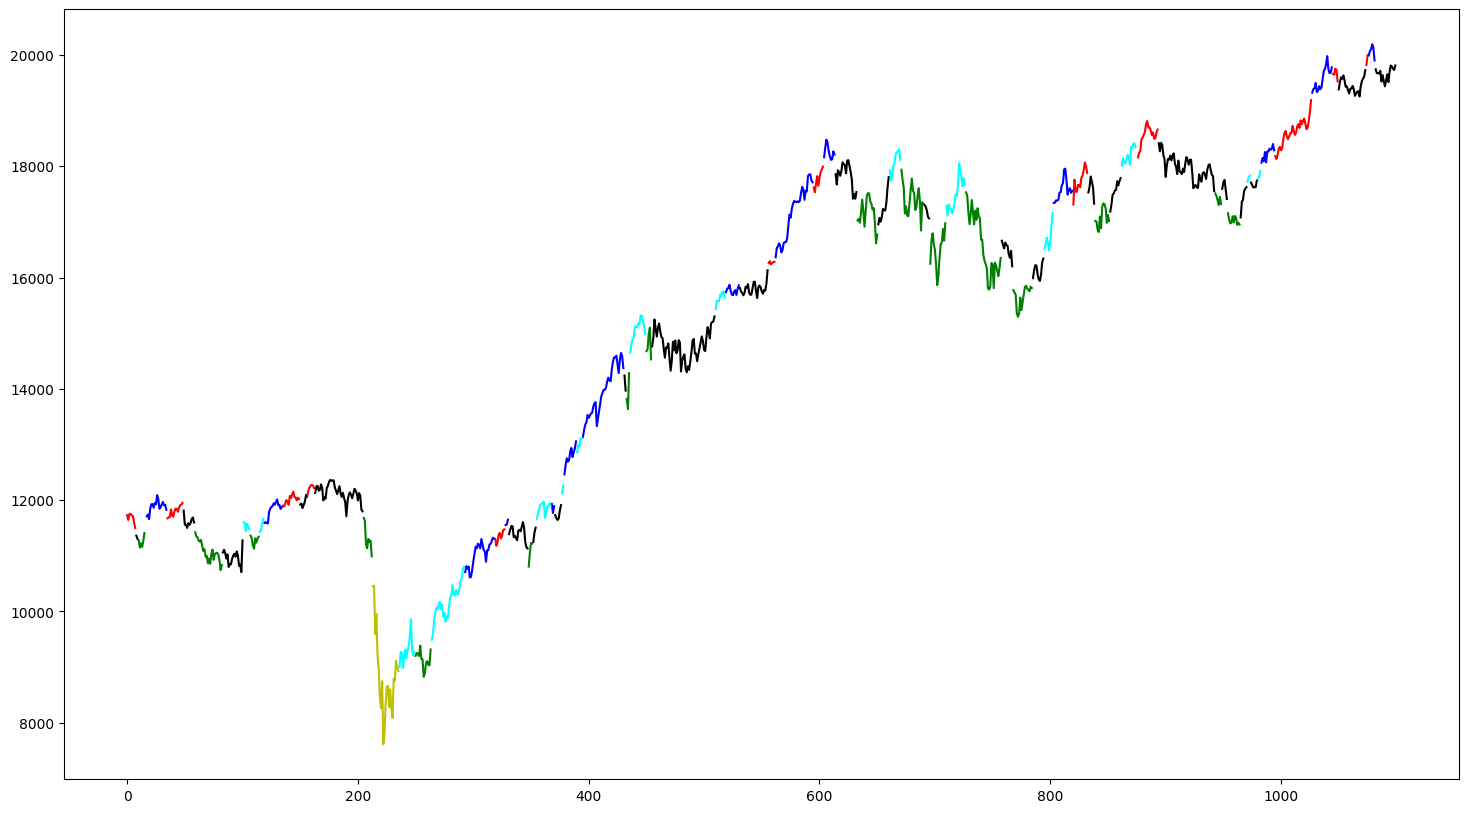

1100


In [491]:
# Plot chart
fig = plt.figure(figsize = (18,10))
plt.plot(labels_0, color="r")
plt.plot(labels_1, color="g")
plt.plot(labels_2, color="k")
plt.plot(labels_3, color="b")
plt.plot(labels_5, color="cyan")
plt.plot(labels_4, color="y")
plt.plot(labels_6, color="grey")
plt.plot(labels_7, color="orange")
plt.plot(labels_8, color="brown")
plt.show()
print(len(labels_0))

In [317]:
# Create the class
class StrategyManager():

    # Initialize the class
    def __init__(self, symbol, start_date, end_date):
        self.df = self._extract_data(symbol, start_date, end_date)
        self.sharpe = 0

    # Extract data
    def _extract_data(self, symbol, start_date, end_date):
        import yfinance as yf
        data = yf.download(symbol, start=start_date, end=end_date)
        data = data[["Open", "High", "Low", "Close", "Volume"]]
        data = self._structure_df(data)
        data['pta-kama'] = pta.kama(data['Close'], 20, 2, 20)
        return data

    # Calculates general period returns and volatility
    def _structure_df(self, df):
        df["Returns"] = df["Close"].pct_change()
        df["Range"] = df["High"] / df["Low"] - 1
        df["Bench_C_Rets"], sharpe = self._calculate_returns(df, True)
        self.sharpe = sharpe
        df.dropna(inplace=True)
        return df

    # Adjusts the signal to represent our strategy
    def _set_multiplier(self, direction):
        if direction == "long":
            pos_multiplier = 1
            neg_multiplier = 0
        elif direction == "long_short":
            pos_multiplier = 1
            neg_multiplier = -1
        else:
            pos_multiplier = 0
            neg_multiplier = -1
        return pos_multiplier, neg_multiplier

    # Calculates returns for equity curve
    def _calculate_returns(self, df, is_benchmark):

        # Calculate multiplier
        if not is_benchmark:
            multiplier_1 = df["Signal"].shift(1)
            multiplier_2 = 1 if "PSignal" not in df.columns else df["PSignal"].shift(1)

            # Assume open price on following day to avoid lookahead bias for close calculation
            log_rets = np.log(df["Open"].shift(-1) / df["Open"]) * multiplier_1 * multiplier_2
        else:
            log_rets = np.log(df["Close"] / df["Close"].shift(1))

        # Calculate Sharpe Ratio
        sharpe_ratio = self.sharpe_ratio(log_rets)

        # Calculate Cumulative Returns
        c_log_rets = log_rets.cumsum()
        c_log_rets_exp = np.exp(c_log_rets) - 1

        # Return result and Sharpe ratio
        return c_log_rets_exp, sharpe_ratio

    def sharpe_ratio(self, return_series):
        N = 255 # Trading days in the year (change to 365 for crypto)
        rf = 0.005 # Half a percent risk free rare
        mean = return_series.mean() * N -rf
        sigma = return_series.std() * np.sqrt(N)
        sharpe = round(mean / sigma, 3)
        return sharpe

    # Replace Dataframe
    def change_df(self, new_df, drop_cols=[]):
        new_df = new_df.drop(columns=drop_cols)
        self.df = new_df

    # Moving average crossover strategy
    def backtest_ma_crossover(self, period_1, period_2, direction, drop_cols=[]):

        # Set df
        df = self.df

        # Get multipliers
        pos_multiplier, neg_multiplier = self._set_multiplier(direction)

        # Calculate Moving Averages
        if f"MA_{period_1}" or f"MA_{period_2}" not in df.columns:
            df[f"MA_{period_1}"] = df["Close"].rolling(window=period_1).mean()
            df[f"MA_{period_2}"] = df["Close"].rolling(window=period_2).mean()
            df.dropna(inplace=True)

        # Calculate Benchmark Returns
        df["Bench_C_Rets"], sharpe_ratio_bench = self._calculate_returns(df, True)

        # Calculate Signal
        df.loc[df[f"MA_{period_1}"] > df[f"MA_{period_2}"], "Signal"] = pos_multiplier
        df.loc[df[f"MA_{period_1}"] <= df[f"MA_{period_2}"], "Signal"] = neg_multiplier
        #df.loc[df["pta-kama"] < df['Close'], "Signal"] = pos_multiplier
        #df.loc[df["pta-kama"] >= df['Close'], "Signal"] = neg_multiplier

        # Calculate Strategy Returns
        df["Strat_C_Rets"], sharpe_ratio_strat = self._calculate_returns(df, False)

        # Get values for output
        bench_rets = df["Bench_C_Rets"].values.astype(float)
        strat_rets = df["Strat_C_Rets"].values.astype(float)
        print("Sense check: ", round(df["Close"].values[-1] / df["Close"].values[0] - 1, 3), round(bench_rets[-1], 3))

        # Remove irrelevant features
        if len(drop_cols) > 0:
            df = df.drop(columns=drop_cols)

        # Ensure Latest DF matches
        df = df.dropna()
        self.df = df

        # Return df
        return df, sharpe_ratio_bench, sharpe_ratio_strat

In [492]:
# Predict Market Regimes
hidden_states_preds = hmm_model.predict(X_test.values)
#hidden_states_preds = hmm_model.predict(X.values)
hidden_states_preds[:10]
#len(hidden_states_preds)

array([0, 2, 2, 2, 1, 1, 1, 1, 1, 1])

In [493]:
# Create an instance
strat_mgr = StrategyManager(tkr,start_dt,end_dt)
# Extract the modified data
df_strat_mgr = strat_mgr.df
df_strat_mgr.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,pta-kama
Date,,,,,,,,,
2024-05-27,23038.949219,23110.800781,22871.199219,22932.449219,260000,-0.001074,0.010476,1.110963,22354.518038
2024-05-28,22977.150391,22998.550781,22858.500000,22888.150391,217900,-0.001932,0.006127,1.106885,22380.680353
2024-05-29,22762.750000,22825.500000,22685.449219,22704.699219,269900,-0.008015,0.006174,1.089999,22384.750365
2024-05-30,22617.449219,22705.750000,22417.000000,22488.650391,373400,-0.009516,0.012881,1.070111,22386.364649
2024-05-31,22568.099609,22653.750000,22465.099609,22530.699219,572100,0.001870,0.008397,1.073982,22388.619641


In [453]:
# Check MA Strategy performance
strat_df, sharpe_b, sharpe_s = strat_mgr.backtest_ma_crossover(5, 15, "long", drop_cols=["High", "Low", "Volume"])
strat_df

Sense check:  0.935 0.935


,Open,Close,Returns,Range,Bench_C_Rets,pta-kama,MA_5,MA_15,Signal,Strat_C_Rets
Date,,,,,,,,,,
2019-04-04,11660.200195,11598.000000,-0.003946,0.008941,-0.003946,1500.558581,11638.860156,11504.080078,1.0,-0.001870
2019-04-05,11638.400391,11665.950195,0.005859,0.006904,0.001889,2819.845398,11658.050195,11525.696745,1.0,0.003786
2019-04-08,11704.349609,11604.500000,-0.005267,0.013958,-0.003388,3729.506957,11645.120117,11543.113411,1.0,-0.004129
2019-04-09,11612.049805,11671.950195,0.005812,0.009871,0.002405,4707.664129,11636.870117,11559.453451,1.0,-0.001145
2019-04-10,11646.849609,11584.299805,-0.007509,0.009359,-0.005123,5201.219845,11624.940039,11567.593424,1.0,-0.005802
...,...,...,...,...,...,...,...,...,...,...
2024-05-24,22930.750000,22957.099609,-0.000459,0.005169,0.971590,22333.302422,22703.540234,22398.683333,1.0,0.519136
2024-05-27,23038.949219,22932.449219,-0.001074,0.010476,0.969473,22354.518038,22796.810156,22429.123307,1.0,0.515061
2024-05-28,22977.150391,22888.150391,-0.001932,0.006127,0.965669,22380.680353,22868.630078,22458.820052,1.0,0.500924


Sharpe Ratio Base Strategy Benchmark:  0.664
Sharpe Ratio Base Strategy:  0.615


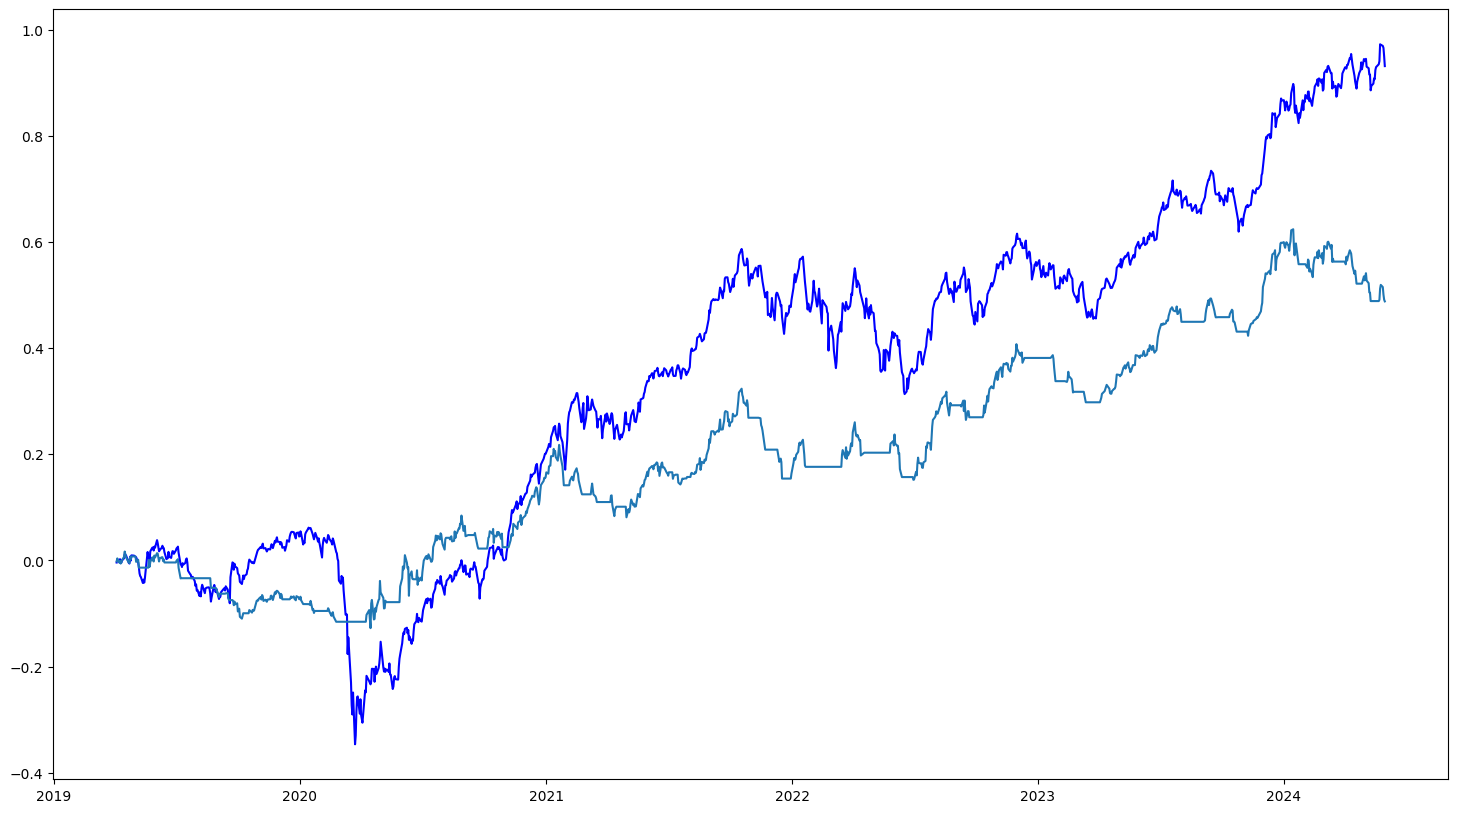

In [454]:
# Review equity curve and metrics
print("Sharpe Ratio Base Strategy Benchmark: ", sharpe_b)
print("Sharpe Ratio Base Strategy: ", sharpe_s)

fig = plt.figure(figsize = (18,10))
plt.plot(strat_df["Bench_C_Rets"], color='b')
plt.plot(strat_df["Strat_C_Rets"])
plt.show()

In [494]:
# Structure Data
#X_train_2 = strat_df[["Returns", "Range"]].iloc[:500] # Train Test Split here
#X_test = strat_df[["Returns", "Range"]].iloc[500:]
#X_train_2.head()
df_strat_mgr_test = strat_df.copy()
#len(X_train_2)

In [495]:
# Set Favourable States - !!!!!!!!! ADJUST BASED ON HMM RESULTS AND TEST OUTCOME !!!!!!!!!!!!!!!!!!!!
favourable_states = [0,3]
unfav_states = [1,2,4]
#hidden_states_preds = hidden_states

# Write Strategy
state_signals = []
for s in hidden_states_preds:
    #if s in favourable_states:
    #    state_signals.append(1)
    #else:
    #    state_signals.append(0)
    if s in unfav_states:
      state_signals.append(0)
    else:
      state_signals.append(1)

print("States: ", state_signals[:10])
print("Lengh of States: ", len(state_signals))

States:  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Lengh of States:  148


In [496]:
sum(state_signals)

55

In [442]:
print(hidden_states_preds)

[3 4 4 4 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3
 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 4 4]


In [497]:
# Structure prices for chart plotting
i = 0
labels_0 = []
labels_1 = []
labels_2 = []
labels_3 = []
labels_5 = []
labels_4 = []
labels_6 = []
labels_7 = []
labels_8 = []
prices= prices_test
#prices = df['Close'].iloc[80:]
#print(prices)
#prices = df["Close"].values.astype(float)
print("Correct Number of rows: ", len(prices) == len(hidden_states_preds))
for s in hidden_states_preds:
    if s == 0:
        labels_0.append(prices[i])
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
        labels_5.append(float('nan'))
        labels_4.append(float('nan'))
        labels_6.append(float('nan'))
        labels_7.append(float('nan'))
        labels_8.append(float('nan'))
    if s == 1:
        labels_0.append(float('nan'))
        labels_1.append(prices[i])
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
        labels_5.append(float('nan'))
        labels_4.append(float('nan'))
        labels_6.append(float('nan'))
        labels_6.append(float('nan'))
        labels_7.append(float('nan'))
        labels_8.append(float('nan'))
    if s == 2:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(prices[i])
        labels_3.append(float('nan'))
        labels_5.append(float('nan'))
        labels_4.append(float('nan'))
        labels_6.append(float('nan'))
        labels_7.append(float('nan'))
        labels_8.append(float('nan'))
    if s == 3:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(prices[i])
        labels_5.append(float('nan'))
        labels_4.append(float('nan'))
        labels_6.append(float('nan'))
        labels_7.append(float('nan'))
        labels_8.append(float('nan'))
    if s == 5:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
        labels_5.append(prices[i])
        labels_4.append(float('nan'))
        labels_6.append(float('nan'))
        labels_7.append(float('nan'))
        labels_8.append(float('nan'))
    if s == 4:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
        labels_5.append(float('nan'))
        labels_4.append(prices[i])
        labels_6.append(float('nan'))
        labels_7.append(float('nan'))
        labels_8.append(float('nan'))
    if s == 6:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
        labels_5.append(float('nan'))
        labels_6.append(prices[i])
        labels_4.append(float('nan'))
        labels_7.append(float('nan'))
        labels_8.append(float('nan'))
    if s == 7:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
        labels_5.append(float('nan'))
        labels_7.append(prices[i])
        labels_4.append(float('nan'))
        labels_6.append(float('nan'))
        labels_8.append(float('nan'))
    if s == 8:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
        labels_5.append(float('nan'))
        labels_8.append(prices[i])
        labels_4.append(float('nan'))
        labels_7.append(float('nan'))
        labels_6.append(float('nan'))
    i += 1

Correct Number of rows:  True


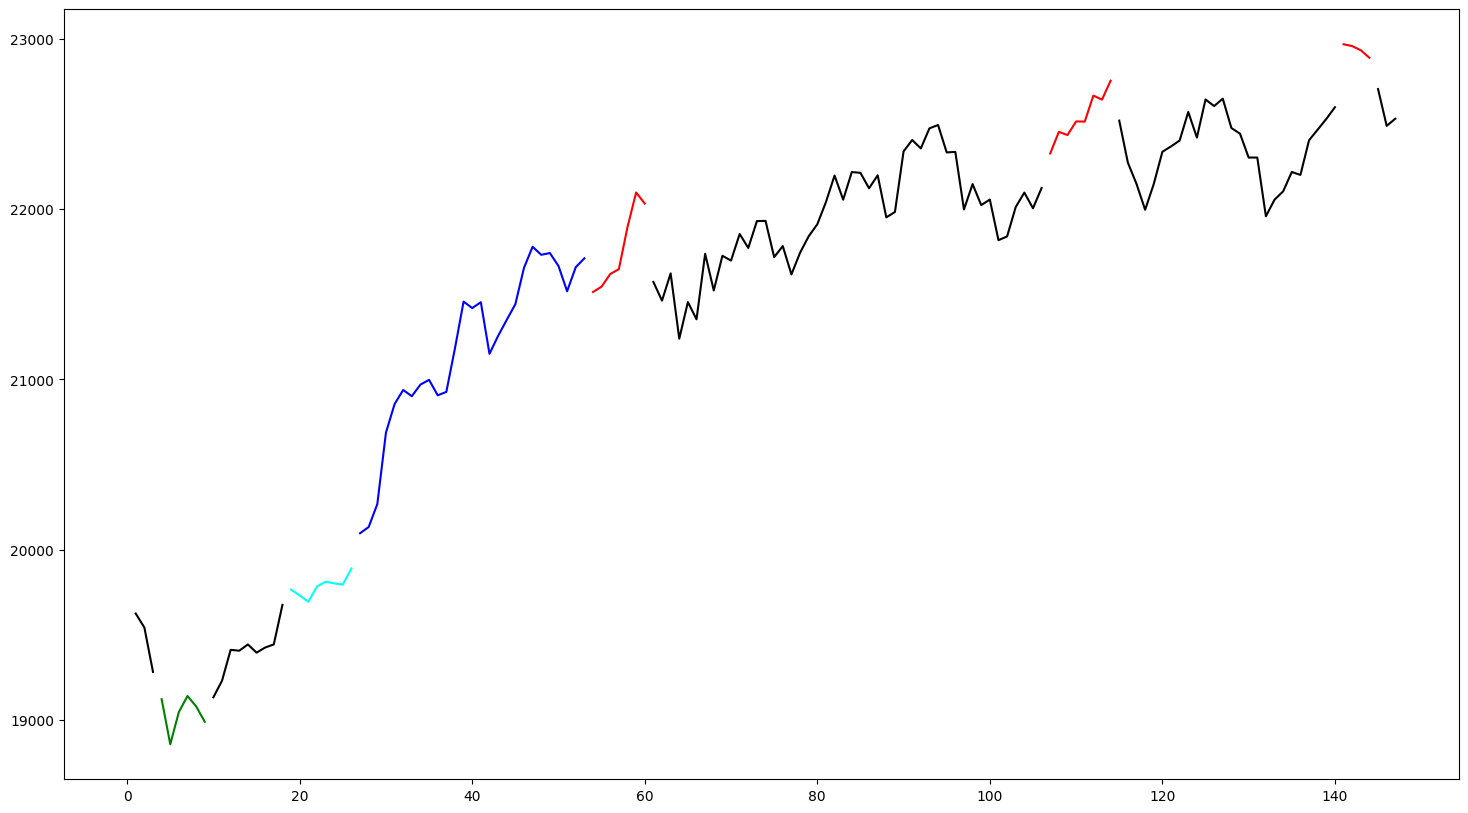

148


In [498]:
# Plot chart
fig = plt.figure(figsize = (18,10))
plt.plot(labels_0, color="r")
plt.plot(labels_1, color="g")
plt.plot(labels_2, color="k")
plt.plot(labels_3, color="b")
plt.plot(labels_5, color="cyan")
plt.plot(labels_4, color="y")
plt.plot(labels_6, color="grey")
plt.plot(labels_7, color="orange")
plt.plot(labels_8, color="brown")
plt.show()
print(len(labels_0))

In [499]:
# Replace Strategy Dataframe
df_strat_mgr_test = df_strat_mgr_test.tail(len(X_test))
#df_strat_mgr_test = df_strat_mgr_test.tail(len(X))
df_strat_mgr_test["PSignal"] = state_signals
strat_mgr.change_df(df_strat_mgr_test)
strat_mgr.df.head()

,Open,Close,Returns,Range,Bench_C_Rets,pta-kama,MA_5,MA_15,Signal,Strat_C_Rets,PSignal
Date,,,,,,,,,,,
2023-10-19,19545.199219,19624.699219,-0.002359,0.008684,0.685399,19777.630266,19718.019922,19648.239974,1.0,0.450010,1
2023-10-20,19542.150391,19542.650391,-0.004181,0.003848,0.678352,19771.511478,19676.339844,19649.513281,1.0,0.448485,0
2023-10-23,19521.599609,19281.750000,-0.013350,0.015526,0.655946,19749.468301,19586.339844,19625.743229,0.0,0.431037,0
2023-10-25,19286.449219,19122.150391,-0.008277,0.014320,0.642239,19711.145313,19448.469922,19598.636589,0.0,0.431037,0
2023-10-26,19027.250000,18857.250000,-0.013853,0.010821,0.619489,19637.824137,19285.700000,19560.046615,0.0,0.431037,0


In [500]:
strat_df_2, sharpe_b_2, sharpe_s_2 = strat_mgr.backtest_ma_crossover(5, 20, "long")
strat_df_2

Sense check:  0.14 0.14


,Open,Close,Returns,Range,Bench_C_Rets,pta-kama,MA_5,MA_15,Signal,Strat_C_Rets,PSignal,MA_20
Date,,,,,,,,,,,,
2023-11-20,19731.150391,19694.000000,-0.001916,0.004369,-0.001916,19503.872864,19662.000000,19397.739974,1.0,0.002015,1,19340.857520
2023-11-21,19770.900391,19783.400391,0.004539,0.003799,0.002615,19510.922928,19729.969922,19440.573307,1.0,0.002678,1,19352.895020
2023-11-22,19784.000000,19811.849609,0.001438,0.006177,0.004057,19530.043087,19757.250000,19489.389974,1.0,0.004931,1,19379.400000
2023-11-23,19828.449219,19802.000000,-0.000497,0.004468,0.003558,19556.733144,19764.610156,19543.579948,1.0,0.003976,1,19413.392480
2023-11-24,19809.599609,19794.699219,-0.000369,0.003237,0.003188,19604.217825,19777.189844,19587.676563,1.0,0.005752,1,19460.264941
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-23,22614.099609,22967.650391,0.016367,0.018432,0.163992,22298.780059,22592.890234,22378.089974,1.0,0.121637,1,22415.614941
2024-05-24,22930.750000,22957.099609,-0.000459,0.005169,0.163457,22333.302422,22703.540234,22398.683333,1.0,0.126930,1,22443.349902
2024-05-27,23038.949219,22932.449219,-0.001074,0.010476,0.162208,22354.518038,22796.810156,22429.123307,1.0,0.123907,1,22461.454883


Sharpe Ratio Benchmark:  2.226
Sharpe Ratio Regime Strategy with MA Cross:  2.645
--- ---
Returns Benchmark: 15.07%
Returns Regime Strategy with MA Cross: 11.34%


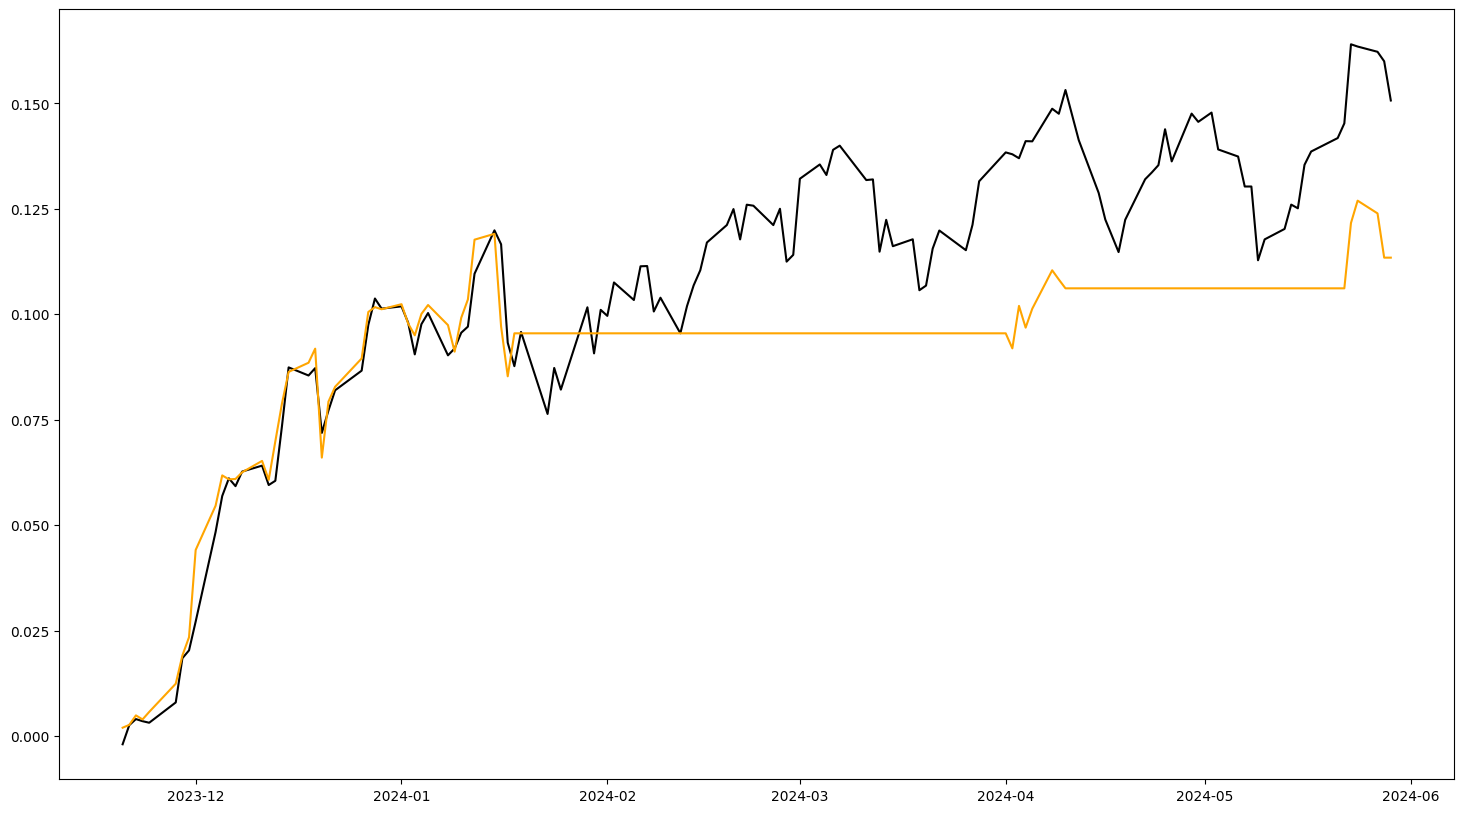

In [501]:
# Review equity curve
print("Sharpe Ratio Benchmark: ", sharpe_b_2)
print("Sharpe Ratio Regime Strategy with MA Cross: ", sharpe_s_2)
print("--- ---")
print(f"Returns Benchmark: {round(strat_df_2['Bench_C_Rets'].values[-1] * 100, 2)}%")
print(f"Returns Regime Strategy with MA Cross: {round(strat_df_2['Strat_C_Rets'].values[-1] * 100, 2)}%")

fig = plt.figure(figsize = (18, 10))
plt.plot(strat_df_2["Bench_C_Rets"], color='k')
plt.plot(strat_df_2["Strat_C_Rets"], color = 'orange')
plt.show()

In [170]:
import pickle
pickle_path = "drive/MyDrive/Colab Notebooks/models/hmm-regime-switching/GOOG_regime_switching.pkl"
with open(pickle_path, "wb") as file: pickle.dump(hmm_model, file)
#hmm_model = pickle.load(open(pickle_path, "rb"))
#with open("CANBK_regime_switching.pkl", "rb") as file: pickle.load(file)